### Analysis on MK data tar file collected using mk_run_ex.sh file

- preparation

In [1]:
pwd

u'/Users/yj/repo/mk/ipynb/analysis'

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os, glob, subprocess, tarfile, dill, shutil,MP
import MP.lib.temp

In [4]:
fnRsync=MP.lib.temp.gen_tempfile()
cwd=os.getcwd()
runRsync="""#!/bin/bash
cd %s
bash rsyncFromPal.sh
cd -"""%cwd
print runRsync
with open(fnRsync,'w') as fo:
    fo.write(runRsync)
    fo.write('\n')
rst=subprocess.check_output(['bash',fnRsync])

#!/bin/bash
cd /Users/yj/repo/mk/ipynb/analysis
bash rsyncFromPal.sh
cd -


In [5]:
fnRsync

'/tmp/ynj/-e2b504-.txt'

In [6]:
!tree ../../ -d 

../../
|-- archive
|-- build
|   |-- lib
|   |   `-- mk
|   |       |-- library
|   |       |-- materials
|   |       |-- tests
|   |       `-- yieldFunction
|   |-- lib.macosx-10.5-x86_64-2.7
|   |   `-- yf_for.so.dSYM
|   |       `-- Contents
|   |           `-- Resources
|   |               `-- DWARF
|   |-- src.macosx-10.5-x86_64-2.7
|   `-- temp.macosx-10.5-x86_64-2.7
|       |-- build
|       |   `-- src.macosx-10.5-x86_64-2.7
|       `-- fortran
|-- docs
|-- fortran
|-- ipynb
|   `-- analysis
|-- man
|   `-- _region_.prv
|-- matDatabase
|   `-- IFsteel
|-- mk
|   |-- bin
|   |-- library
|   |-- materials
|   |-- tests
|   |-- tool
|   `-- yieldFunction
|       `-- _region_.prv
|           `-- tmp6243nji
`-- tests

36 directories


In [7]:
ls -lstr ../../archive/ |tail -n 5

 1704 -rw-r--r--  1 yj  admin   870400 Aug  8 17:49 MKVARHARD_0.996_20160808-1749-1c05b3-.tar
 1704 -rw-r--r--  1 yj  admin   870400 Aug  8 17:49 MKVARHARD_0.994_20160808-1749-9fec8e-.tar
 1704 -rw-r--r--  1 yj  admin   870400 Aug  8 17:54 MKVARHARD_0.992_20160808-1753-420a16-.tar
 9144 -rw-r--r--  1 yj  admin  4679680 Aug  9 07:11 MKVARHARD_0.998_20160809-0711-d6e0bf-.tar
 9464 -rw-r--r--  1 yj  admin  4843520 Aug  9 09:00 MKVARHARD_0.996_20160809-0900-d424bf-.tar


In [8]:
## VPSC 
# fns_master=glob.glob('MKVPSCHARD_*_20160806*.tar')
## MK
# fns_master=glob.glob('mk_*_20160730*.tar')
## VPSC-MK - 20160808
# fns_master = ['MKVPSCHARD_0.996_20160808-0115-1ff82a-.tar']
# fns_master = glob.glob('MKVPSCHARD_0.9??_20160808-12*.tar')
# fns_master = glob.glob('MKVPSCHARD_0.9??_20160808-15*.tar') ## VPSC hardening 
# fns_master=glob.glob('../../archive/MKVARHARD_0.9??_20160808-17??-*.tar')

fns_master=glob.glob('../../archive/MKVARHARD_0.9??_20160809-0???-*.tar')

fns_master.sort()
for i in xrange(len(fns_master)):
    print fns_master[i]

# subprocess.check_call(['tar','-tf',fn])
# members = subprocess.check_output(['tar','-tf',fns_master[0]]).split()

../../archive/MKVARHARD_0.996_20160809-0900-d424bf-.tar
../../archive/MKVARHARD_0.998_20160809-0711-d6e0bf-.tar


In [9]:
def loadFLDmin(fn='minFLD.txt'):
    dat=np.loadtxt(fn,dtype='str').T
    if len(dat)==0:
        ## no results found in minFLD.txt
        a=np.zeros((9,1))
        a[::]=np.nan
    else:
        a=np.array(dat[:9],dtype='float')
    # exx,eyy,thi,thf,sx,sy,sigbar,epsbar,dt=dat[:9]
    return a

In [10]:
class member:
    def __init__(self,fn=None):
        """
        Argument
        --------
        fn
        """
        self.fn = fn
        ## check the rule.
        eps_eq, yflab, hflab, path, f0 =  self.fn.split('_')[1:6]

        self.eps_eq = float(eps_eq)
        self.yflab  = yflab
        self.hflab  = hflab
        self.hardpath = path
        self.f0       = float(f0)

        ## 
        cmd = ['tar','-tf',self.fn]
        self.members=subprocess.check_output(cmd).split('\n')[:-1]
        self.members.sort()
        self.fldfn=self.members[1]

        ## find out min file
        cmd=['tar','-xf',self.fn, self.fldfn]
        if subprocess.check_call(cmd)!=0:
            raise IOError
        exx,eyy,thi,thf,sx,sy,sigbar,epsbar,dt = loadFLDmin(self.fldfn)
        
        ths = np.arctan2(eyy,exx)##TD,RD
        rad = np.sqrt(exx**2+eyy**2)
        
        os.remove(self.fldfn)
        self.flc = np.array([exx,eyy])

class EachMK: ## for each MKVPSCHARD file (fixed f0 value)
    def __init__(self,fn):
        cmd=['tar','-tf',fn]
        self.fns_member = subprocess.check_output(cmd).split()        
        self.members=[]
        self.nmem = len(self.fns_member)

        self.eps_eqs = []
        self.yflabs  = []
        self.hflabs  = []
        self.hardpaths = []
        self.f0s       = []
        
        inds = np.zeros((len(self.fns_member),4))
        
        for i in xrange(len(self.fns_member)): ## 1d to (w,x,y,z)
            subprocess.check_call(['tar','-xf',fn,self.fns_member[i]])
            self.members.append(member(fn = self.fns_member[i]))
            
            if not(self.members[i].eps_eq in self.eps_eqs):
                self.eps_eqs.append(self.members[i].eps_eq)
            if not(self.members[i].yflab in self.yflabs):
                self.yflabs.append(self.members[i].yflab)
            if not(self.members[i].hflab in self.hflabs):
                self.hflabs.append(self.members[i].hflab)
            if not(self.members[i].hardpath in self.hardpaths):
                self.hardpaths.append(self.members[i].hardpath)
            if not(self.members[i].f0 in self.f0s):
                self.f0s.append(self.members[i].f0)
            os.remove(self.fns_member[i])

        w, x, y, z = self.yflabs, self.hflabs, self.hardpaths, self.eps_eqs

    def find_mem(self,iyf,ihf,ipath,ieps,verbose):
        """
        Arguments
        ---------
        iyf
        ihf
        ipath
        ieps
        verbose
        """
        yfl = self.yflabs[iyf]
        hfl = self.hflabs[ihf]
        hpt = self.hardpaths[ipath]
        eps = self.eps_eqs[ieps]
        
        if verbose:
            print 'yf lab:', yfl
            print 'hf lab:', hfl
            print 'hpt   :', hpt
            print 'eps   :', eps
        
        ind=-1
        for i in xrange(len(self.members)):
            eachMem=self.members[i]
            if eachMem.yflab==yfl and eachMem.hflab==hfl \
               and eachMem.hardpath==hpt and eachMem.eps_eq==eps:
                ind=i;break
                    
        if ind==-1: raise IOError
                    
        return ind, yfl, hfl, hpt, eps
        ## find out in what dimension the FLD data are.

- class that finds the best f0 value for the given condition

In [11]:
class master:
    def __init__(self,fns):
        self.eachMKs=[]
        for i in xrange(len(fns)):
            self.eachMKs.append(EachMK(fns[i]))
        self.eachMKs=np.array(self.eachMKs)
        self.get_exp()
        
    def get_exp(self,fn='/Users/yj/repo/vpsc/vpsc-dev-fld/ipynb/FLD/IFsteel_EXP/FLDexp.dill'):
        with open(fn,'r') as fo:
            self.exp_FLC=dill.load(fo)
            
    def compareFit_ind(self,iyf=0,ihf=0,ipath=0,ieps=0,iplot=False):
        """
        Find best f0 value for each by plotting them.
        
        Arguments
        ---------
        iyf
        ihf
        ipath
        ieps
        iplot
        """
        inds=[]
        collectionMK=[]
        collectionMK_fn=[]
        for i in xrange(len(self.eachMKs)): ## each f0s
            each = self.eachMKs[i]
            if i==0: verbose=True
            else:    verbose=False
            ind, yfl, hfl, hpt, eps = each.find_mem(iyf,ihf,ipath,ieps,verbose)
            self.eachMKs[i].members[ind].flc
            inds.append(ind)
            collectionMK.append(self.eachMKs[i].members[ind])
            collectionMK_fn.append(self.eachMKs[i].members[ind].fldfn)

        if iplot:
            fig=plt.figure(); ax=fig.add_subplot(111)            
            y,x,yerr,xerr = self.exp_FLC[:,0],self.exp_FLC[:,1],\
                            self.exp_FLC[:,2],self.exp_FLC[:,3]
            ax.errorbar(x=x,y=y,xerr=xerr,yerr=yerr,marker='None',ls='None')
            ax.set_aspect('equal')
            ax.set_xlabel(r'$\mathrm{\bar{E}_{22}}$',fontsize=14)
            ax.set_ylabel(r'$\mathrm{\bar{E}_{11}}$',fontsize=14)
            ax.set_title('%s %s %s %.2f'%(yfl,hfl,hpt,eps))
            
            for i in xrange(len(collectionMK)):
                dat=collectionMK[i].flc
                f0 = collectionMK[i].f0
                ax.plot(dat[0],dat[1],label=f0)
                print 'fld file name:',collectionMK_fn[i]
                
            ax.grid('on')
            ax.legend()
        return collectionMK

In [12]:
# %%timeit
%time
myMaster=master(fns_master)

CPU times: user 7 µs, sys: 3 µs, total: 10 µs
Wall time: 16 µs


/Users/yj/anaconda/lib/python2.7/site-packages/numpy/lib/npyio.py:893: UserWarning: loadtxt: Empty input file: "minFLD-eb4ff2.txt"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)


yf lab: H48R
hf lab: Swift
hpt   : U
eps   : 0.01
fld file name: minFLD-8684b6.txt
fld file name: minFLD-e2400c.txt


[<__main__.member instance at 0x105ef2248>,
 <__main__.member instance at 0x105f08cb0>]

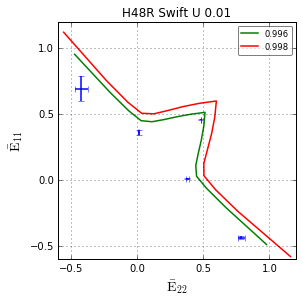

In [13]:
myMaster.compareFit_ind(iyf=0,ihf=0,ipath=0,ieps=0,iplot=True)